In [33]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
from sklearn.linear_model import LinearRegression
import h5py
import networkx as nx
from sklearn.neighbors import NearestNeighbors
import maxflow
from PIL import Image, ImageOps
from scipy.spatial import KDTree
from skimage.filters import threshold_otsu
import lifelines
from lifelines import KaplanMeierFitter, CoxPHFitter
from lifelines.statistics import logrank_test

# 予後データの読み込み

In [2]:
tcga_rep_data = pd.read_csv('./prog_data/stad_tcga_pan_can_atlas_2018_clinical_data.tsv',delimiter= "\t")

In [3]:
tcga_rep_data.head()

,Study ID,Patient ID,Sample ID,Diagnosis Age,Neoplasm Disease Stage American Joint Committee on Cancer Code,American Joint Committee on Cancer Publication Version Type,Aneuploidy Score,Cancer Type,TCGA PanCanAtlas Cancer Type Acronym,Cancer Type Detailed,...,Subtype,Tumor Break Load,Tissue Prospective Collection Indicator,Tissue Retrospective Collection Indicator,Tissue Source Site,Tissue Source Site Code,TMB (nonsynonymous),Tumor Disease Anatomic Site,Tumor Type,Patient Weight
0,stad_tcga_pan_can_atlas_2018,TCGA-3M-AB46,TCGA-3M-AB46-01,70.0,STAGE IB,6TH,11.0,Esophagogastric Cancer,STAD,Stomach Adenocarcinoma,...,STAD_CIN,110.0,No,Yes,University of Kansas Medical Center,3M,5.600000,Stomach,Stomach Adenocarcinoma (NOS),NaN
1,stad_tcga_pan_can_atlas_2018,TCGA-3M-AB47,TCGA-3M-AB47-01,51.0,STAGE IIIB,6TH,6.0,Esophagogastric Cancer,STAD,Stomach Adenocarcinoma,...,STAD_GS,30.0,No,Yes,University of Kansas Medical Center,3M,3.566667,Stomach,Stomach Adenocarcinoma (NOS),NaN
2,stad_tcga_pan_can_atlas_2018,TCGA-B7-5816,TCGA-B7-5816-01,51.0,STAGE IIB,7TH,2.0,Esophagogastric Cancer,STAD,Diffuse Type Stomach Adenocarcinoma,...,STAD_MSI,48.0,No,Yes,Cureline,B7,40.100000,Stomach,"Stomach Adenocarcinoma, Diffuse Type",NaN
3,stad_tcga_pan_can_atlas_2018,TCGA-B7-5818,TCGA-B7-5818-01,62.0,STAGE IB,7TH,9.0,Esophagogastric Cancer,STAD,Diffuse Type Stomach Adenocarcinoma,...,STAD_EBV,41.0,No,Yes,Cureline,B7,11.500000,Stomach,"Stomach Adenocarcinoma, Diffuse Type",NaN
4,stad_tcga_pan_can_atlas_2018,TCGA-B7-A5TI,TCGA-B7-A5TI-01,52.0,STAGE IIIC,7TH,4.0,Esophagogastric Cancer,STAD,Diffuse Type Stomach Adenocarcinoma,...,STAD_MSI,87.0,Yes,No,Cureline,B7,18.433333,Stomach,"Stomach Adenocarcinoma, Diffuse Type",NaN


In [4]:
tcga_rep_data.columns

Index(['Study ID', 'Patient ID', 'Sample ID', 'Diagnosis Age',
       'Neoplasm Disease Stage American Joint Committee on Cancer Code',
       'American Joint Committee on Cancer Publication Version Type',
       'Aneuploidy Score', 'Cancer Type',
       'TCGA PanCanAtlas Cancer Type Acronym', 'Cancer Type Detailed',
       'Last Communication Contact from Initial Pathologic Diagnosis Date',
       'Birth from Initial Pathologic Diagnosis Date',
       'Last Alive Less Initial Pathologic Diagnosis Date Calculated Day Value',
       'Disease Free (Months)', 'Disease Free Status',
       'Months of disease-specific survival',
       'Disease-specific Survival status', 'Ethnicity Category',
       'Form completion date', 'Fraction Genome Altered',
       'Genetic Ancestry Label', 'Neoplasm Histologic Grade',
       'Neoadjuvant Therapy Type Administered Prior To Resection Text',
       'ICD-10 Classification',
       'International Classification of Diseases for Oncology, Third Edition IC

# 別のdataをrefに

In [5]:
raw_prog_data = pd.read_excel('./prog_data/TCGA-CDR-SupplementalTableS1.xlsx',sheet_name="ExtraEndpoints")
raw_prog_data.head()

,Unnamed: 0,bcr_patient_barcode,type,PFI.1,PFI.time.1,PFI.2,PFI.time.2,PFS,PFS.time,DSS_cr,DSS.time.cr,DFI.cr,DFI.time.cr,PFI.cr,PFI.time.cr,PFI.1.cr,PFI.time.1.cr,PFI.2.cr,PFI.time.2.cr
0,1,TCGA-OR-A5J1,ACC,1.0,754.0,1.0,754.0,1.0,754.0,1.0,1355.0,1.0,754.0,1.0,754.0,1.0,754.0,1.0,754.0
1,2,TCGA-OR-A5J2,ACC,1.0,289.0,1.0,289.0,1.0,289.0,1.0,1677.0,NaN,NaN,1.0,289.0,1.0,289.0,1.0,289.0
2,3,TCGA-OR-A5J3,ACC,1.0,53.0,1.0,53.0,1.0,53.0,0.0,2091.0,1.0,53.0,1.0,53.0,1.0,53.0,1.0,53.0
3,4,TCGA-OR-A5J4,ACC,1.0,126.0,1.0,126.0,1.0,126.0,1.0,423.0,NaN,NaN,1.0,126.0,1.0,126.0,1.0,126.0
4,5,TCGA-OR-A5J5,ACC,1.0,50.0,1.0,50.0,1.0,50.0,1.0,365.0,NaN,NaN,1.0,50.0,1.0,50.0,1.0,50.0


In [6]:
raw_prog_data = pd.merge(tcga_rep_data, raw_prog_data, left_on='Patient ID', right_on='bcr_patient_barcode', how='inner')

In [7]:
raw_prog_data

,Study ID,Patient ID,Sample ID,Diagnosis Age,Neoplasm Disease Stage American Joint Committee on Cancer Code,American Joint Committee on Cancer Publication Version Type,Aneuploidy Score,Cancer Type,TCGA PanCanAtlas Cancer Type Acronym,Cancer Type Detailed,...,DSS_cr,DSS.time.cr,DFI.cr,DFI.time.cr,PFI.cr,PFI.time.cr,PFI.1.cr,PFI.time.1.cr,PFI.2.cr,PFI.time.2.cr
0,stad_tcga_pan_can_atlas_2018,TCGA-3M-AB46,TCGA-3M-AB46-01,70.0,STAGE IB,6TH,11.0,Esophagogastric Cancer,STAD,Stomach Adenocarcinoma,...,0.0,1765.0,0.0,1765.0,0.0,1765.0,0.0,1765.0,0.0,1765.0
1,stad_tcga_pan_can_atlas_2018,TCGA-3M-AB47,TCGA-3M-AB47-01,51.0,STAGE IIIB,6TH,6.0,Esophagogastric Cancer,STAD,Stomach Adenocarcinoma,...,1.0,NaN,NaN,NaN,1.0,395.0,1.0,395.0,1.0,395.0
2,stad_tcga_pan_can_atlas_2018,TCGA-B7-5816,TCGA-B7-5816-01,51.0,STAGE IIB,7TH,2.0,Esophagogastric Cancer,STAD,Diffuse Type Stomach Adenocarcinoma,...,0.0,812.0,0.0,812.0,0.0,812.0,0.0,812.0,0.0,812.0
3,stad_tcga_pan_can_atlas_2018,TCGA-B7-5818,TCGA-B7-5818-01,62.0,STAGE IB,7TH,9.0,Esophagogastric Cancer,STAD,Diffuse Type Stomach Adenocarcinoma,...,0.0,356.0,NaN,NaN,0.0,356.0,0.0,356.0,0.0,356.0
4,stad_tcga_pan_can_atlas_2018,TCGA-B7-A5TI,TCGA-B7-A5TI-01,52.0,STAGE IIIC,7TH,4.0,Esophagogastric Cancer,STAD,Diffuse Type Stomach Adenocarcinoma,...,0.0,595.0,0.0,595.0,0.0,595.0,0.0,595.0,0.0,595.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
435,stad_tcga_pan_can_atlas_2018,TCGA-VQ-AA6I,TCGA-VQ-AA6I-01,68.0,STAGE IIIB,7TH,15.0,Esophagogastric Cancer,STAD,Intestinal Type Stomach Adenocarcinoma,...,1.0,491.0,NaN,NaN,1.0,475.0,1.0,475.0,1.0,475.0
436,stad_tcga_pan_can_atlas_2018,TCGA-VQ-AA6J,TCGA-VQ-AA6J-01,75.0,STAGE IIIB,7TH,9.0,Esophagogastric Cancer,STAD,Intestinal Type Stomach Adenocarcinoma,...,0.0,838.0,0.0,838.0,0.0,838.0,0.0,838.0,0.0,838.0
437,stad_tcga_pan_can_atlas_2018,TCGA-VQ-AA6K,TCGA-VQ-AA6K-01,59.0,STAGE IIIC,6TH,14.0,Esophagogastric Cancer,STAD,Signet Ring Cell Carcinoma of the Stomach,...,1.0,378.0,NaN,NaN,1.0,332.0,1.0,332.0,1.0,332.0
438,stad_tcga_pan_can_atlas_2018,TCGA-ZA-A8F6,TCGA-ZA-A8F6-01,71.0,STAGE IB,7TH,7.0,Esophagogastric Cancer,STAD,Intestinal Type Stomach Adenocarcinoma,...,0.0,525.0,0.0,525.0,0.0,525.0,0.0,525.0,0.0,525.0


In [8]:
raw_prog_data.columns

Index(['Study ID', 'Patient ID', 'Sample ID', 'Diagnosis Age',
       'Neoplasm Disease Stage American Joint Committee on Cancer Code',
       'American Joint Committee on Cancer Publication Version Type',
       'Aneuploidy Score', 'Cancer Type',
       'TCGA PanCanAtlas Cancer Type Acronym', 'Cancer Type Detailed',
       'Last Communication Contact from Initial Pathologic Diagnosis Date',
       'Birth from Initial Pathologic Diagnosis Date',
       'Last Alive Less Initial Pathologic Diagnosis Date Calculated Day Value',
       'Disease Free (Months)', 'Disease Free Status',
       'Months of disease-specific survival',
       'Disease-specific Survival status', 'Ethnicity Category',
       'Form completion date', 'Fraction Genome Altered',
       'Genetic Ancestry Label', 'Neoplasm Histologic Grade',
       'Neoadjuvant Therapy Type Administered Prior To Resection Text',
       'ICD-10 Classification',
       'International Classification of Diseases for Oncology, Third Edition IC

In [9]:
sample_name = [f"{sample_name}-01Z-00-DX1" for sample_name in raw_prog_data["Patient ID"].tolist()]
sample_age = raw_prog_data['Diagnosis Age'].tolist()

sample_T = raw_prog_data['American Joint Committee on Cancer Tumor Stage Code'].str.extract(r'^(T[1-4])')[0].fillna(raw_prog_data['American Joint Committee on Cancer Tumor Stage Code']).tolist()
sample_N = raw_prog_data['Neoplasm Disease Lymph Node Stage American Joint Committee on Cancer Code'].tolist()
sample_M = raw_prog_data['American Joint Committee on Cancer Metastasis Stage Code'].tolist()


age_dict =dict(zip(sample_name, sample_age))

T_dict = dict(zip(sample_name, sample_T))
N_dict = dict(zip(sample_name, sample_N))
M_dict =dict(zip(sample_name, sample_M))


sample_stage = raw_prog_data['Neoplasm Disease Stage American Joint Committee on Cancer Code'].tolist()
stage_dict =dict(zip(sample_name, sample_stage))



In [10]:

###DSS がんによる死亡，DFI 寛解したのちの再発
#prog_data=raw_prog_data[raw_prog_data["bcr_patient_barcode"].isin(sample_name_list_with_tumsize)]

#prog_data=raw_prog_data[raw_prog_data['Neoplasm Disease Stage American Joint Committee on Cancer Code'].isin(['STAGE III', 'STAGE IIIA', 'STAGE IIIB', 'STAGE IIIC'])]

prog_data=raw_prog_data[raw_prog_data["Subtype"]=="STAD_CIN"]

#prog_data = raw_prog_data

OS_df = prog_data[pd.notna(prog_data["Overall Survival Status"])]
#OS_df = prog_data[prog_data["Overall Survival Status"]=="1:DECEASED"]
OS_df = OS_df[pd.notna(OS_df["Overall Survival (Months)"])]
OS_sample_name = [f"{sample_name}-01Z-00-DX1" for sample_name in OS_df["Patient ID"].tolist()]
OS_time = OS_df["Overall Survival (Months)"].tolist()
OS_index = OS_df["Overall Survival Status"].tolist()
OS_index = [int(temp_index[0]) for temp_index in OS_index]
OS_index_dict=dict(zip(OS_sample_name, OS_index))
OS_dict = dict(zip(OS_sample_name, OS_time))


DSS_df = prog_data[pd.notna(prog_data["DSS_cr"])]
#DSS_df = prog_data[prog_data["DSS_cr"]==1]
DSS_df = DSS_df[pd.notna(DSS_df["DSS.time.cr"])]
DSS_sample_name = [f"{sample_name}-01Z-00-DX1" for sample_name in DSS_df["bcr_patient_barcode"].tolist()]
DSS_time = DSS_df["DSS.time.cr"].tolist()
DSS_time=[temp_DSS/30 for temp_DSS in DSS_time]
DSS_index_dict=dict(zip(DSS_sample_name, DSS_df["DSS_cr"].tolist()))
DSS_dict = dict(zip(DSS_sample_name, DSS_time))

PFS_df = prog_data[pd.notna(prog_data["PFS"])]
#PFS_df = prog_data[prog_data["PFS"]==1]
PFS_df = PFS_df[pd.notna(PFS_df["PFS.time"])]
PFS_sample_name = [f"{sample_name}-01Z-00-DX1" for sample_name in PFS_df["bcr_patient_barcode"].tolist()]
PFS_time = PFS_df["PFS.time"].tolist()
PFS_time=[temp_PFS/30 for temp_PFS in PFS_time]
PFS_index_dict=dict(zip(PFS_sample_name, PFS_df["PFS"].tolist()))
PFS_dict = dict(zip(PFS_sample_name, PFS_time))

DFI_df = prog_data[pd.notna(prog_data["DFI.cr"])]
#DFI_df = prog_data[prog_data["DFI.cr"]==1]
DFI_df = DFI_df[pd.notna(DFI_df["DFI.time.cr"])]
DFI_sample_name = [f"{sample_name}-01Z-00-DX1" for sample_name in DFI_df["bcr_patient_barcode"].tolist()]
DFI_time = DFI_df["DFI.time.cr"].tolist()
DFI_time=[temp_DFI/30 for temp_DFI in DFI_time]
DFI_index_dict=dict(zip(DFI_sample_name, DFI_df["DFI.cr"].tolist()))
DFI_dict = dict(zip(DFI_sample_name, DFI_time))

PFI_df = prog_data[pd.notna(prog_data["PFI.cr"])]
#PFI_df = prog_data[prog_data["PFI.cr"]==1]
PFI_df = PFI_df[pd.notna(PFI_df["PFI.time.cr"])]
PFI_sample_name = [f"{sample_name}-01Z-00-DX1" for sample_name in PFI_df["bcr_patient_barcode"].tolist()]
PFI_time = PFI_df["PFI.time.cr"].tolist()
PFI_time=[temp_PFI/30 for temp_PFI in PFI_time]
PFI_index_dict=dict(zip(PFI_sample_name, PFI_df["PFI.cr"].tolist()))
PFI_dict = dict(zip(PFI_sample_name, PFI_time))

prog_dict =PFI_dict
prog_index_dict = PFI_index_dict



In [11]:

def create_knn_graph(coords, k=4):
    """
    k-NNグラフを構築
    - coords: xy座標 (N, 2)
    - features: 各点の特徴量 (N, F) でFは特徴量の次元数
    - k: 近傍数
    """
    n = len(coords)
    
    # k-NNモデルの作成 (xy座標に基づいて近傍を計算)
    neighbors = NearestNeighbors(n_neighbors=k + 1)  # 自分自身を含むため +1
    neighbors.fit(coords)
    
    # k-NNの距離とインデックスを計算
    distances, indices = neighbors.kneighbors(coords)

    # maxflowグラフの作成
    g = maxflow.Graph[int]()
    nodes = g.add_nodes(n)

    # NetworkXでグラフ可視化用
    nx_graph = nx.Graph()

    # k-NNでエッジを追加
    for i in range(n):
        for j in range(1, k + 1):  # 自分自身は除外するため1からスタート
            neighbor_idx = indices[i, j]

            # エッジの重み (featureの相関係数) - 事前に計算した相関行列を使用　cos simが高いほど，weight==異なるclusterになった場合のpenalty は小さい
            weight = 1

            # pymaxflowのグラフにエッジを追加
            g.add_edge(nodes[i], nodes[neighbor_idx], weight, weight)

            # NetworkXのグラフにも追加
            nx_graph.add_edge(i, neighbor_idx, weight=weight)

    return g, nodes, nx_graph





def compute_cluster_connected_components(nx_graph, node_cluster):
    """
    各クラスタの連結成分数と割合を計算
    
    - nx_graph: networkxのグラフ
    - node_cluster: 各ノードのクラスタ情報 (リスト or numpy配列)
    
    Returns:
        - cluster_components: 各クラスタの連結成分数 (dict: cluster_id -> int)
        - cluster_component_ratios: 各クラスタ内の成分の割合リスト (dict: cluster_id -> list)
    """
    # クラスタごとにノードを分類
    clusters = {}
    for node, cluster_id in enumerate(node_cluster):
        if cluster_id not in clusters:
            clusters[cluster_id] = []
        clusters[cluster_id].append(node)
    
    cluster_components = {}
    cluster_component_ratios = {}

    # 各クラスタについて処理
    for cluster_id, nodes in clusters.items():
        # クラスタのサブグラフを作成
        subgraph = nx_graph.subgraph(nodes)
        
        # 連結成分を取得
        components = list(nx.connected_components(subgraph))
        num_components = len(components)
        
        # 各成分のサイズ
        component_sizes = np.array([len(comp) for comp in components])
        
        # クラスタ内での割合
        component_ratios = component_sizes / sum(component_sizes)
        
        # 結果を格納
        cluster_components[cluster_id] = num_components
        cluster_component_ratios[cluster_id] = component_ratios.tolist()

    return cluster_components, cluster_component_ratios




Otsu threshold: 3.7886202270795994
Low attention cluster count: 195
High attention cluster count: 244


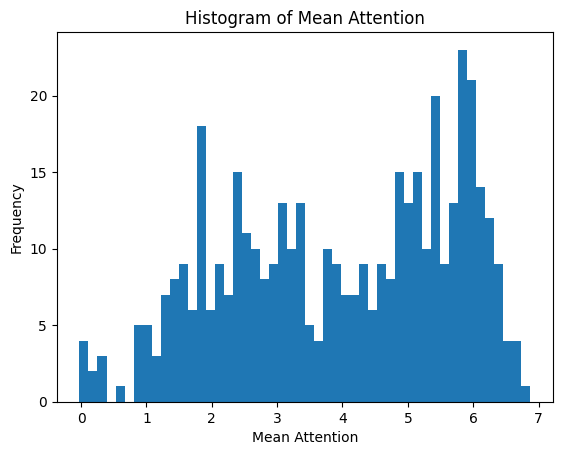

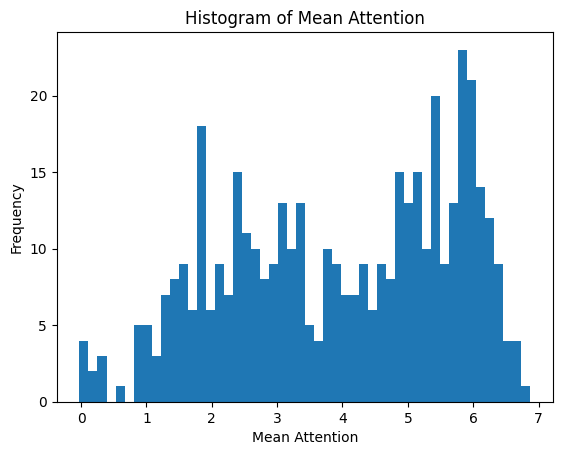

In [34]:
dir_path = "/home/shirasuna/work/hetero_path/hetero_cluster/clustering_pca80var_integrate_mag40/"

samples_with_cluster_all = [
    f for f in os.listdir(dir_path) 
    if os.path.isdir(os.path.join(dir_path,f)) and f.startswith("TCGA")
]

cluster_chief_list = []


samples_with_cluster = list(set(samples_with_cluster_all)&set(list(prog_dict.keys())))

    
for temp_sample in samples_with_cluster:
    path_2_clustering = f"{dir_path}/{temp_sample}"
    optimized_state = np.load(f"{path_2_clustering}/optimized_state.npy")
    h5_file_path = f"/data/shirasuna/work/hetero_path/TCGA_wsi_patch/patched_STAD_mag40/patches/{temp_sample}.h5"
    h5_wsi = h5py.File(h5_file_path, 'r')

    EPI_FEATURE_SAVE_DIR_PATH = f"/data/shirasuna/work/hetero_path/UNI_encode_with_mask/features_mag40/{temp_sample}"
    epi_coords = np.load(f"{EPI_FEATURE_SAVE_DIR_PATH}/coords.npy")
    #epi_features = np.load(f"{EPI_FEATURE_SAVE_DIR_PATH}/features.npy")

    estimated_clone_num= len(np.unique(optimized_state))

    # chief
    chief_result_path =  f"/wsi/analysis/TCGA_TMA_analysis/data/CHIEF/STAD/chief/results/TCGA_Dataset_PT_trident/evaluation/TCGA_CHIEF_test/attention_heatmap_h5_coords_viz_v1/{temp_sample}_patch_attention.csv"
    chief_result_df = pd.read_csv(chief_result_path)

    
    # 4つの近傍のattension valueの平均で各座標のattension valueを定義
    x_coord_chief = chief_result_df["x_coord"].tolist()
    y_coord_chief = chief_result_df["y_coord"].tolist()
    attension_chief_list = chief_result_df["attention_value"].tolist()
    
    coord_chief = np.stack((x_coord_chief, y_coord_chief), axis =1)
    attension_chief_array = np.array(attension_chief_list) # shape=(N,) 例: (2903,)

    # --- KDTree を使用した最近傍探索 ---
    kdtree = KDTree(coord_chief)
    
    # 2. wsi_patch_coords の各点について、coord_tum_chief 内の最近傍点を検索
    #    queryメソッドは、距離(distances)と最近傍点のインデックス(indices)を返します。
    #    k=1 は最も近い1点を探すことを意味します。
    distances, nearest_indices = kdtree.query(epi_coords, k=4)
    
    # nearest_indices は、wsi_patch_coords の各点に対応する、
    # coord_tum_chief 内の最も近い点のインデックス（行番号）を格納した配列です。
    # shape=(M,) 例: (42849,)
    
    # 3. 得られたインデックスを使って、対応する attention 値を取得
    #    attension_chief_array から、nearest_indices を使って値を取り出します。

    wsi_attention_values = attension_chief_array[nearest_indices] # shape=(M,) 例: (42849,)
        
    ###平均のattension valueが4以上のclusterのみカウント

    mean_wsi_attention_values = np.mean(wsi_attention_values, axis=1)
    
    estimated_clone_num=0

    patch_num = 0
    for cluster in np.unique(optimized_state):
        mean_attension = np.sum(mean_wsi_attention_values[optimized_state==cluster])/np.sum(optimized_state==cluster)
        cluster_chief_list.append(mean_attension)


# 大津のしきい値を計算
cluster_chief_array = np.array(cluster_chief_list)
otsu_thresh = threshold_otsu(cluster_chief_array)

# 分割
low_attention = cluster_chief_array[cluster_chief_array <= otsu_thresh]
high_attention = cluster_chief_array[cluster_chief_array > otsu_thresh]

print(f"Otsu threshold: {otsu_thresh}")
print(f"Low attention cluster count: {len(low_attention)}")
print(f"High attention cluster count: {len(high_attention)}")



plt.hist(cluster_chief_list, bins=50)
plt.xlabel("Mean Attention")
plt.ylabel("Frequency")
plt.title("Histogram of Mean Attention")
plt.show()
    
    

Otsu threshold: 3.8964257834032168
Low attention cluster count: 205
High attention cluster count: 234


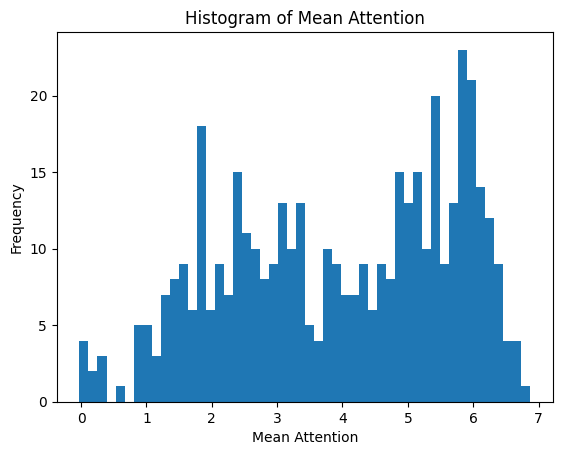

In [37]:

from skimage.filters import threshold_minimum


# 大津のしきい値を計算
cluster_chief_array = np.array(cluster_chief_list)
otsu_thresh = threshold_minimum(cluster_chief_array)

# 分割
low_attention = cluster_chief_array[cluster_chief_array <= otsu_thresh]
high_attention = cluster_chief_array[cluster_chief_array > otsu_thresh]

print(f"Otsu threshold: {otsu_thresh}")
print(f"Low attention cluster count: {len(low_attention)}")
print(f"High attention cluster count: {len(high_attention)}")



plt.hist(cluster_chief_list, bins=50)
plt.xlabel("Mean Attention")
plt.ylabel("Frequency")
plt.title("Histogram of Mean Attention")
plt.show()
    
    

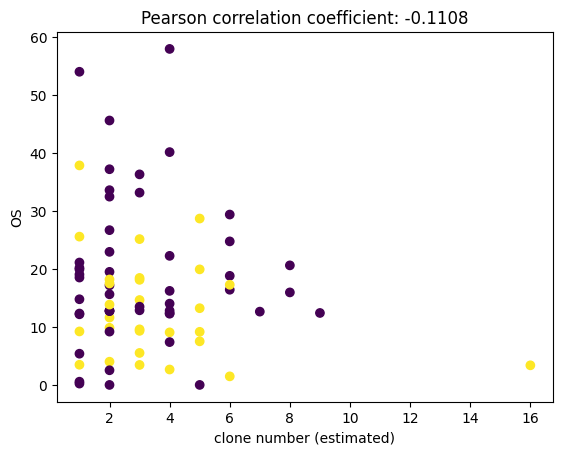

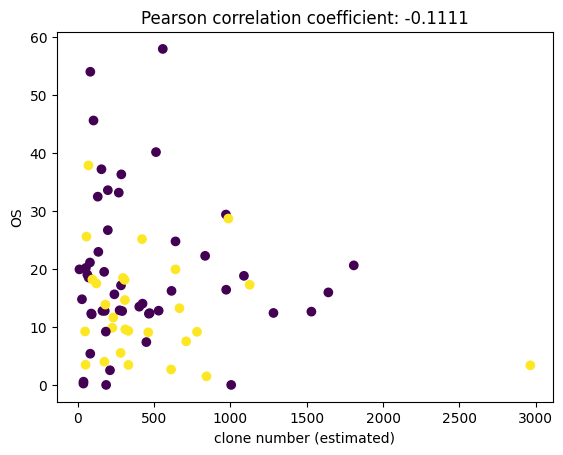

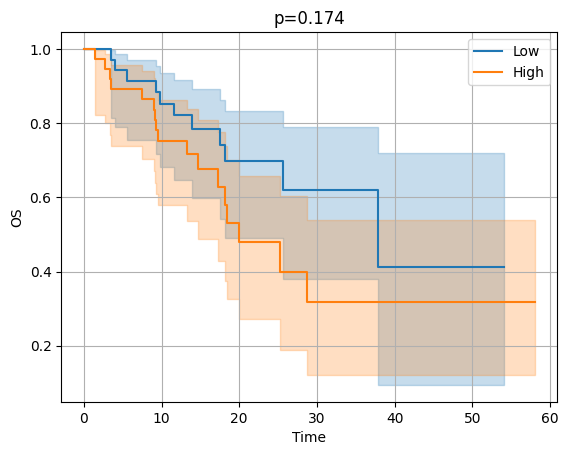

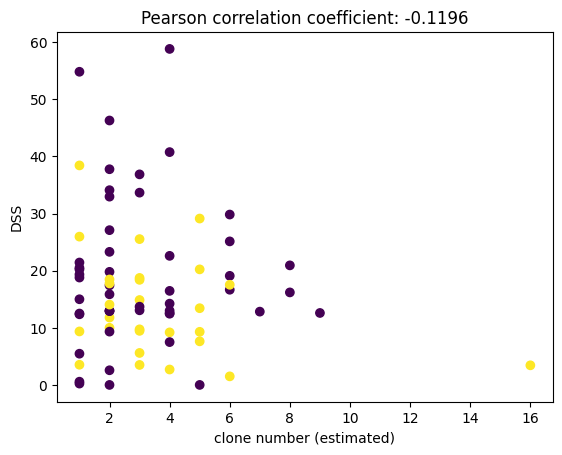

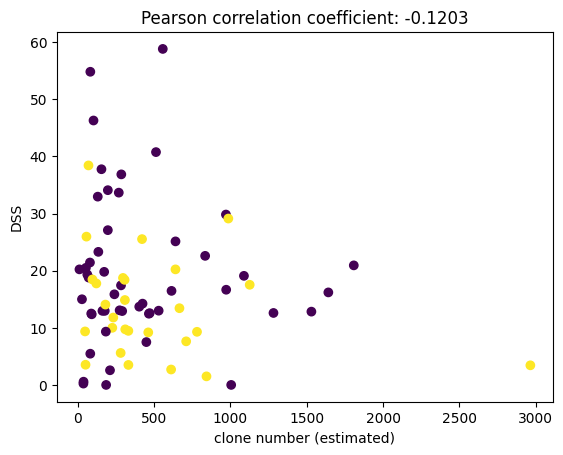

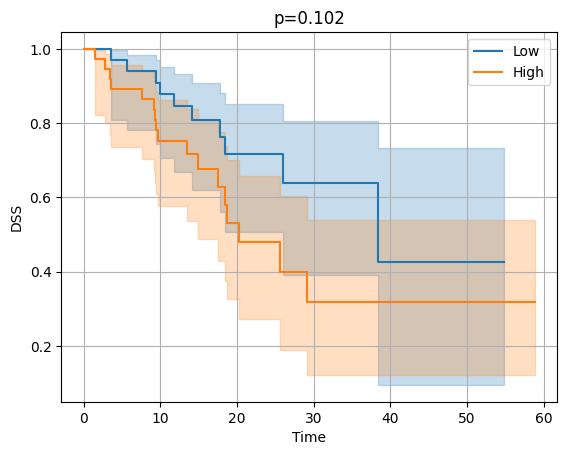

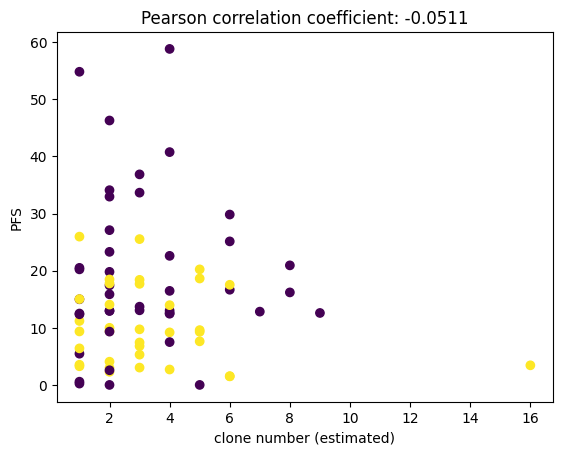

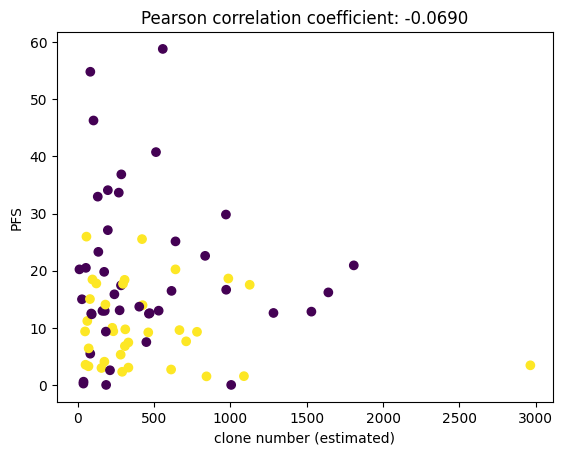

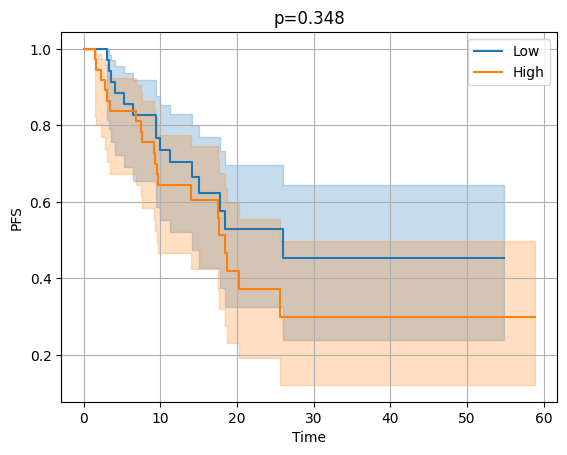

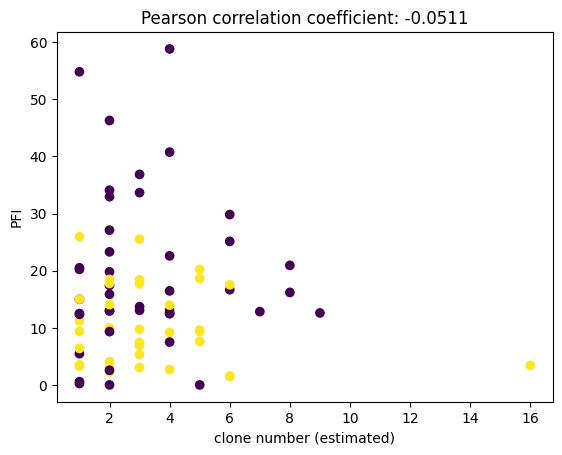

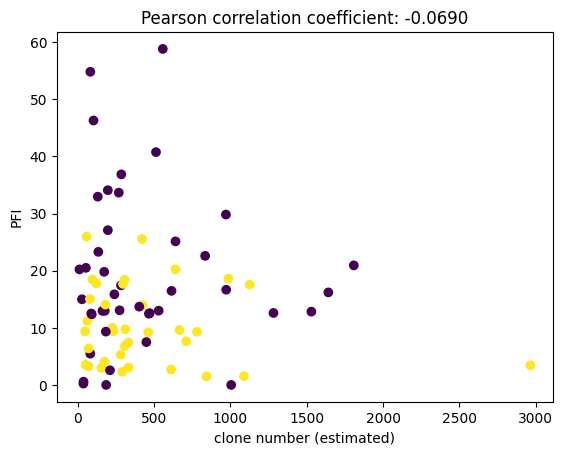

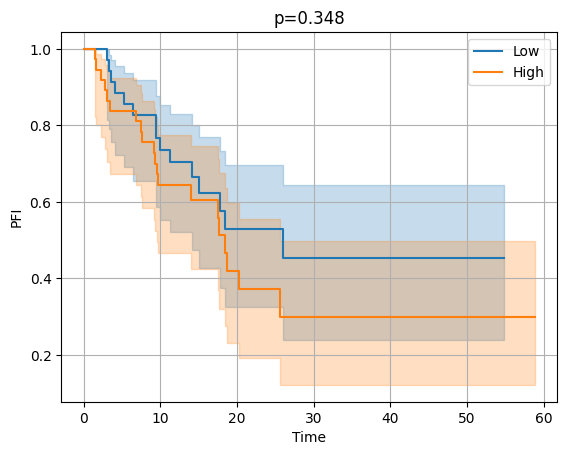

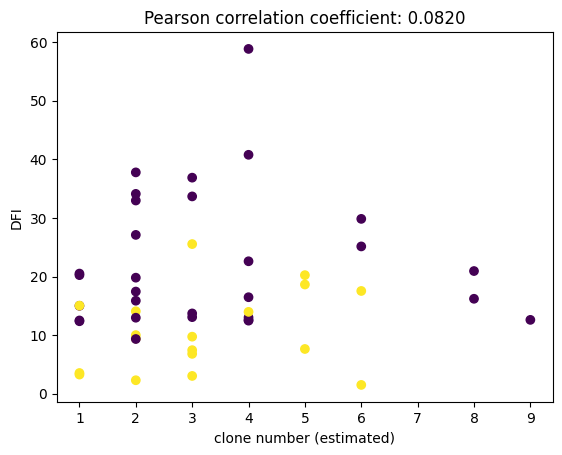

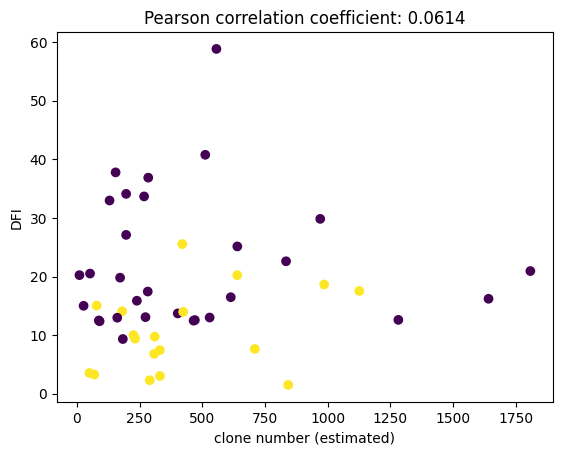

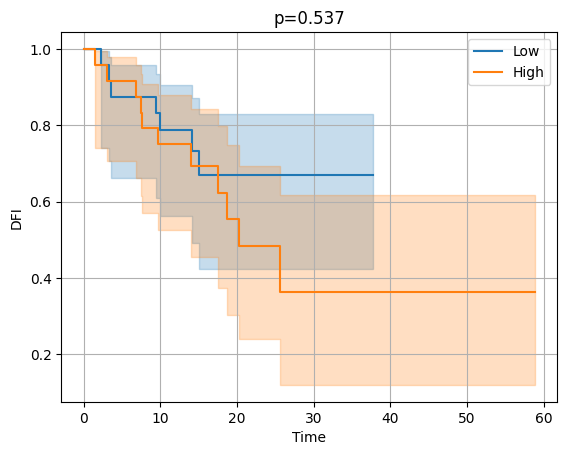

In [38]:
"""
prog_dict_list=[OS_dict,PFS_dict, DFI_dict]
prog_index_dict_list=[OS_index_dict,PFS_index_dict, DFI_index_dict]
metrics_name_list = ["OS", "PFS", "DFI"]
"""
prog_dict_list=[OS_dict, DSS_dict,PFS_dict,PFI_dict, DFI_dict]
prog_index_dict_list=[OS_index_dict, DSS_index_dict,PFS_index_dict,PFI_index_dict, DFI_index_dict]
metrics_name_list = ["OS", "DSS", "PFS", "PFI", "DFI"]

tum_threshold_value_in_chief=otsu_thresh

dir_path = "/home/shirasuna/work/hetero_path/hetero_cluster/clustering_pca80var_integrate_mag40_init20/"

samples_with_cluster_all = [
    f for f in os.listdir(dir_path) 
    if os.path.isdir(os.path.join(dir_path,f)) and f.startswith("TCGA")
]

###WGSと相関が取れるもののみ使用

"""
import pickle
# 読み込み
with open('good_samples.pkl', 'rb') as f:
    good_samples = pickle.load(f)
samples_with_cluster_all=list(set(samples_with_cluster_all)&set(good_samples))
"""



for i in range(len(metrics_name_list)):
    prog_dict = prog_dict_list[i]
    prog_index_dict = prog_index_dict_list[i]
    metrics_name=metrics_name_list[i]
    samples_with_cluster = list(set(samples_with_cluster_all)&set(list(prog_dict.keys())))

    
    prog_list=[]
    samples_for_plot_list=[]
    estimated_clone_num_list = []
    whole_patch_num_list = []
    patch_num_list = []
    tum_whole_ratio_list = []
    
    for temp_sample in samples_with_cluster:
        path_2_clustering = f"{dir_path}/{temp_sample}"
        optimized_state = np.load(f"{path_2_clustering}/optimized_state.npy")
        h5_file_path = f"/data/shirasuna/work/hetero_path/TCGA_wsi_patch/patched_STAD_mag40/patches/{temp_sample}.h5"
        h5_wsi = h5py.File(h5_file_path, 'r')
    
        EPI_FEATURE_SAVE_DIR_PATH = f"/data/shirasuna/work/hetero_path/UNI_encode_with_mask/features_mag40/{temp_sample}"
        epi_coords = np.load(f"{EPI_FEATURE_SAVE_DIR_PATH}/coords.npy")
        #epi_features = np.load(f"{EPI_FEATURE_SAVE_DIR_PATH}/features.npy")
    
        estimated_clone_num= len(np.unique(optimized_state))
    
        # chief
        chief_result_path =  f"/wsi/analysis/TCGA_TMA_analysis/data/CHIEF/STAD/chief/results/TCGA_Dataset_PT_trident/evaluation/TCGA_CHIEF_test/attention_heatmap_h5_coords_viz_v1/{temp_sample}_patch_attention.csv"
        chief_result_df = pd.read_csv(chief_result_path)
    
        
        # 4つの近傍のattension valueの平均で各座標のattension valueを定義
        x_coord_chief = chief_result_df["x_coord"].tolist()
        y_coord_chief = chief_result_df["y_coord"].tolist()
        attension_chief_list = chief_result_df["attention_value"].tolist()
        
        coord_chief = np.stack((x_coord_chief, y_coord_chief), axis =1)
        attension_chief_array = np.array(attension_chief_list) # shape=(N,) 例: (2903,)

        # --- KDTree を使用した最近傍探索 ---
        kdtree = KDTree(coord_chief)
        
        # 2. wsi_patch_coords の各点について、coord_tum_chief 内の最近傍点を検索
        #    queryメソッドは、距離(distances)と最近傍点のインデックス(indices)を返します。
        #    k=1 は最も近い1点を探すことを意味します。
        distances, nearest_indices = kdtree.query(epi_coords, k=4)
        
        # nearest_indices は、wsi_patch_coords の各点に対応する、
        # coord_tum_chief 内の最も近い点のインデックス（行番号）を格納した配列です。
        # shape=(M,) 例: (42849,)
        
        # 3. 得られたインデックスを使って、対応する attention 値を取得
        #    attension_chief_array から、nearest_indices を使って値を取り出します。

        wsi_attention_values = attension_chief_array[nearest_indices] # shape=(M,) 例: (42849,)
        
        ###平均のattension valueが4以上のclusterのみカウント
    
        mean_wsi_attention_values = np.mean(wsi_attention_values, axis=1)
        
        estimated_clone_num=0

        patch_num = 0
        for cluster in np.unique(optimized_state):
            mean_attension = np.sum(mean_wsi_attention_values[optimized_state==cluster])/np.sum(optimized_state==cluster)
            if mean_attension > tum_threshold_value_in_chief:
                estimated_clone_num+=1
                patch_num+=np.sum(optimized_state==cluster)
    
    
        # 例: create_knn_graph の出力を使用
    
        """
       
        g, nodes, nx_graph = create_knn_graph(epi_coords, k=4)  # coords は事前に定義されているとする
        cluster_components, cluster_component_ratios = compute_cluster_connected_components(nx_graph, optimized_state)
        
        print(f"クラスタごとの連結成分数: {cluster_components}")
        
        estimated_clone_num=0
        
        for cluster in cluster_component_ratios.keys():
            #if max(cluster_component_ratios[cluster])>0.25 and sum(optimized_state==cluster)/len(optimized_state)>1/len(np.unique(optimized_state))/5:
            if max(cluster_component_ratios[cluster])*sum(optimized_state==cluster) > 0.01*len(optimized_state):
                estimated_clone_num+=1
        """
        #estimated_clone_num= len(np.unique(optimized_state))
    
        
        prog_time = prog_dict[temp_sample]
        whole_patch_num= len(h5_wsi["coords"])
    
        samples_for_plot_list.append(temp_sample)
        prog_list.append(prog_time)
        estimated_clone_num_list.append(estimated_clone_num)
        patch_num_list.append(patch_num)
        whole_patch_num_list.append(whole_patch_num)
        tum_whole_ratio_list.append(patch_num/whole_patch_num)


    patch_25 = np.percentile(patch_num_list, 0)
    patch_75 = np.percentile(patch_num_list, 100)
    
    filtered_samples_for_plot_list=[]
    filtered_prog_list = []
    filtered_estimated_clone_num_list = []
    filtered_whole_patch_num_list = []
    filtered_patch_num_list = []
    filtered_tum_whole_ratio_list = []
    
    for i in range(len(samples_for_plot_list)):
        if patch_25<patch_num_list[i] and patch_75>patch_num_list[i]:
            filtered_samples_for_plot_list.append(samples_for_plot_list[i])
            filtered_prog_list.append(prog_list[i])
            filtered_estimated_clone_num_list.append(estimated_clone_num_list[i])
            filtered_whole_patch_num_list.append(whole_patch_num_list[i])
            filtered_patch_num_list.append(patch_num_list[i])
            filtered_tum_whole_ratio_list.append(tum_whole_ratio_list[i])


    #filtered_tum_size_list = [tum_size_dict[patient] for patient in filtered_samples_for_plot_list]

    #filtered_scaled_estimated_clone_num_list = [filtered_estimated_clone_num_list[i]*filtered_tum_size_list[i]/(filtered_patch_num_list[i]) for i in range(len(filtered_patch_num_list))]

    filtered_scaled_estimated_clone_num_list = [filtered_estimated_clone_num_list[i]*(filtered_patch_num_list[i])**(1/2) for i in range(len(filtered_patch_num_list))]

    #filtered_scaled_estimated_clone_num_list = [filtered_estimated_clone_num_list[i]*filtered_tum_size_list[i]/(filtered_whole_patch_num_list[i]) for i in range(len(filtered_patch_num_list))]
    #filtered_scaled_estimated_clone_num_list = [filtered_tum_size_list[i]/((filtered_whole_patch_num_list[i]/filtered_estimated_clone_num_list[i])**(3/2)) for i in range(len(filtered_patch_num_list))]

    #filtered_scaled_estimated_clone_num_list = [filtered_estimated_clone_num_list[i]/(filtered_whole_patch_num_list[i]) for i in range(len(filtered_patch_num_list))]
    
    event_list = []
    for temp_sample in filtered_samples_for_plot_list:
        #temp_index = int(prog_index_dict[temp_sample][0])
        temp_index = prog_index_dict[temp_sample]
        if temp_index ==0:
            event_list.append(0)
        else:
            event_list.append(1)
    

    
    corr_pearson = np.corrcoef(filtered_estimated_clone_num_list, filtered_prog_list)[0, 1]
    #print(f"Pearson correlation coefficient: {corr_pearson:.4f}")
    plt.scatter(filtered_estimated_clone_num_list, filtered_prog_list,c=event_list)
    plt.title(f"Pearson correlation coefficient: {corr_pearson:.4f}")
    plt.xlabel("clone number (estimated)")
    plt.ylabel(metrics_name) 
    plt.show()

    corr_pearson = np.corrcoef(filtered_scaled_estimated_clone_num_list, filtered_prog_list)[0, 1]
    #print(f"Pearson correlation coefficient: {corr_pearson:.4f}")
    plt.scatter(filtered_scaled_estimated_clone_num_list, filtered_prog_list,c=event_list)
    plt.title(f"Pearson correlation coefficient: {corr_pearson:.4f}")
    plt.xlabel("clone number (estimated)")
    plt.ylabel(metrics_name) 
    plt.show()





    low_threshold = np.percentile(filtered_scaled_estimated_clone_num_list, 50)
    high_threshold = np.percentile(filtered_scaled_estimated_clone_num_list, 50)

    
    # 上位25%（Q3以上）と下位25%（Q1以下）のインデックスを抽出
    group0_indices = [i for i, val in enumerate(filtered_scaled_estimated_clone_num_list) if val <= low_threshold]
    group1_indices = [i for i, val in enumerate(filtered_scaled_estimated_clone_num_list) if val > high_threshold]

    

    # 対応する生存時間とイベント情報を取得
    T = np.array(filtered_prog_list)
    E = np.array(event_list)
    
    # グループごとのデータ
    T0, E0 = T[group0_indices], E[group0_indices]
    T1, E1 = T[group1_indices], E[group1_indices]

    
    # KMプロット
    kmf = KaplanMeierFitter()
    plt.figure()
    
    kmf.fit(T0, event_observed=E0, label="Low")
    kmf.plot_survival_function()
    
    kmf.fit(T1, event_observed=E1, label="High")
    kmf.plot_survival_function()

    # Log-rank test
    results = logrank_test(T0, T1, event_observed_A=E0, event_observed_B=E1,  weightings='wilcoxon')
    
    plt.title(f"p={results.p_value:.3f}")
    plt.xlabel("Time")
    plt.ylabel(f"{metrics_name}")
    plt.legend()
    plt.grid(True)

    
    plt.show()

    

# cox比例ハザード

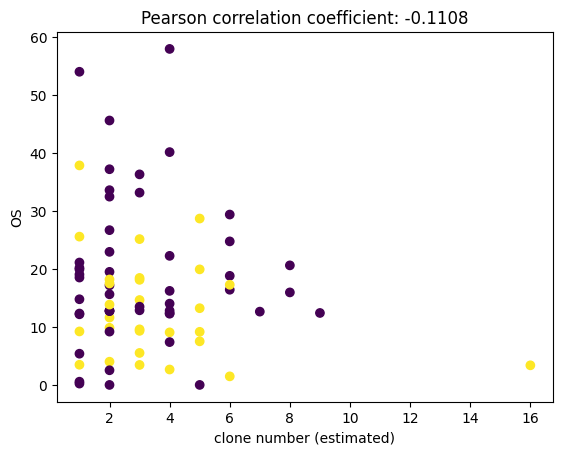

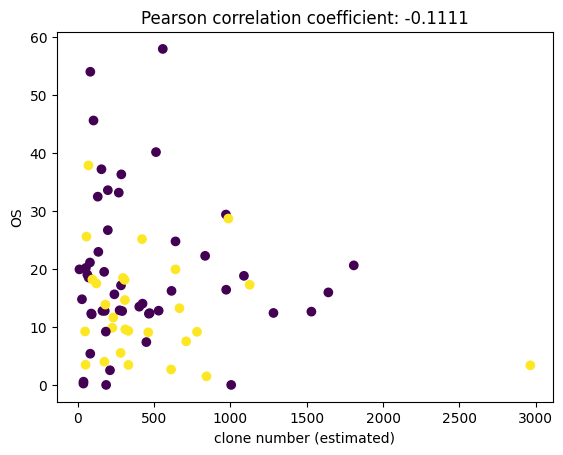

OS


/home/shirasuna/anaconda3/envs/hetero_path_dev/lib/python3.9/site-packages/lifelines/utils/__init__.py:1120: ConvergenceWarning: Column node_NX have very low variance when conditioned on death event present or not. This may harm convergence. This could be a form of 'complete separation'. For example, try the following code:

>>> events = df['event'].astype(bool)
>>> print(df.loc[events, 'node_NX'].var())
>>> print(df.loc[~events, 'node_NX'].var())

A very low variance means that the column node_NX completely determines whether a subject dies or not. See https://stats.stackexchange.com/questions/11109/how-to-deal-with-perfect-separation-in-logistic-regression.

  warnings.warn(dedent(warning_text), ConvergenceWarning)
/home/shirasuna/anaconda3/envs/hetero_path_dev/lib/python3.9/site-packages/lifelines/fitters/coxph_fitter.py:1607: ConvergenceWarning: Newton-Raphson convergence completed successfully but norm(delta) is still high, 0.114. This may imply non-unique solutions to the maximum

<lifelines.CoxPHFitter: fitted with 77 total observations, 49 right-censored observations>
             duration col = 'duration'
                event col = 'event'
      baseline estimation = breslow
   number of observations = 77
number of events observed = 28
   partial log-likelihood = -94.92
         time fit was run = 2025-05-08 06:42:21 UTC

---
             coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                    
age          0.03      1.03      0.02           -0.02            0.08                0.98                1.08
clone_num    0.89      2.45      0.43            0.04            1.75                1.05                5.73
tumor_T3_4   0.74      2.10      0.69           -0.62            2.10                0.54                8.17
node_N1      0.21      1.23      0.67           -1.11            1.53                0.33                4.61
node_N2      1.06      2.88      0.61           -0.15            2.26                0.86                9.58
node_N3      1.06      2.87      0.62           -0.16            2.28                0.85                9.73
node_NX    -13.74      0.00   2308.05        -4537.44         4509.97                0.00                 inf
meta_M1      1.66      5.25      0.77            0.16            3.16                1.17               23.63
meta_MX      0.15      1.17      1.11           -2.01            2.32                0.13               10.21

            cmp to     z    p  -log2(p)
covariate                              
age           0.00  1.23 0.22      2.18
clone_num     0.00  2.06 0.04      4.67
tumor_T3_4    0.00  1.07 0.28      1.82
node_N1       0.00  0.31 0.75      0.41
node_N2       0.00  1.72 0.09      3.55
node_N3       0.00  1.70 0.09      3.48
node_NX       0.00 -0.01 1.00      0.01
meta_M1       0.00  2.16 0.03      5.03
meta_MX       0.00  0.14 0.89      0.17
---
Concordance = 0.70
Partial AIC = 207.84
log-likelihood ratio test = 16.05 on 9 df
-log2(p) of ll-ratio test = 3.93

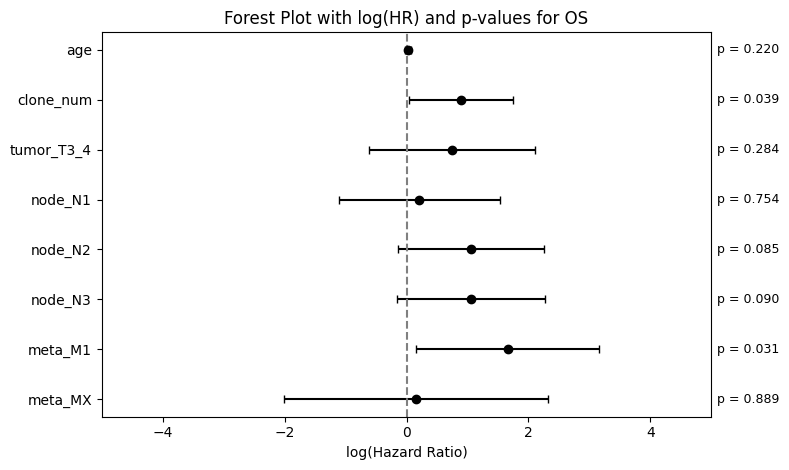

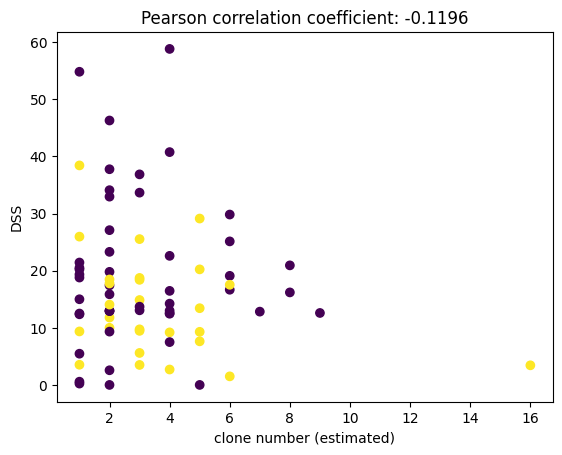

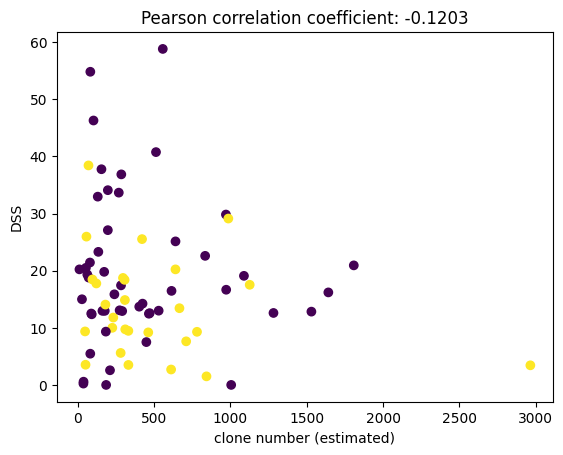

DSS


/home/shirasuna/anaconda3/envs/hetero_path_dev/lib/python3.9/site-packages/lifelines/utils/__init__.py:1120: ConvergenceWarning: Column node_NX have very low variance when conditioned on death event present or not. This may harm convergence. This could be a form of 'complete separation'. For example, try the following code:

>>> events = df['event'].astype(bool)
>>> print(df.loc[events, 'node_NX'].var())
>>> print(df.loc[~events, 'node_NX'].var())

A very low variance means that the column node_NX completely determines whether a subject dies or not. See https://stats.stackexchange.com/questions/11109/how-to-deal-with-perfect-separation-in-logistic-regression.

  warnings.warn(dedent(warning_text), ConvergenceWarning)
/home/shirasuna/anaconda3/envs/hetero_path_dev/lib/python3.9/site-packages/lifelines/fitters/coxph_fitter.py:1607: ConvergenceWarning: Newton-Raphson convergence completed successfully but norm(delta) is still high, 0.115. This may imply non-unique solutions to the maximum

<lifelines.CoxPHFitter: fitted with 76 total observations, 49 right-censored observations>
             duration col = 'duration'
                event col = 'event'
      baseline estimation = breslow
   number of observations = 76
number of events observed = 27
   partial log-likelihood = -91.82
         time fit was run = 2025-05-08 06:42:26 UTC

---
             coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                    
age          0.03      1.03      0.03           -0.02            0.07                0.98                1.08
clone_num    0.95      2.58      0.44            0.08            1.82                1.08                6.16
tumor_T3_4   0.73      2.07      0.69           -0.63            2.08                0.53                8.01
node_N1      0.26      1.30      0.67           -1.04            1.57                0.35                4.82
node_N2      1.07      2.91      0.61           -0.14            2.27                0.87                9.67
node_N3      1.02      2.78      0.63           -0.21            2.25                0.81                9.48
node_NX    -13.74      0.00   2254.83        -4433.13         4405.64                0.00                 inf
meta_M1      1.31      3.70      0.88           -0.42            3.04                0.66               20.86
meta_MX      0.11      1.12      1.11           -2.06            2.28                0.13                9.82

            cmp to     z    p  -log2(p)
covariate                              
age           0.00  1.02 0.31      1.70
clone_num     0.00  2.13 0.03      4.92
tumor_T3_4    0.00  1.05 0.29      1.77
node_N1       0.00  0.40 0.69      0.53
node_N2       0.00  1.74 0.08      3.61
node_N3       0.00  1.63 0.10      3.27
node_NX       0.00 -0.01 1.00      0.01
meta_M1       0.00  1.48 0.14      2.86
meta_MX       0.00  0.10 0.92      0.12
---
Concordance = 0.70
Partial AIC = 201.64
log-likelihood ratio test = 13.70 on 9 df
-log2(p) of ll-ratio test = 2.91

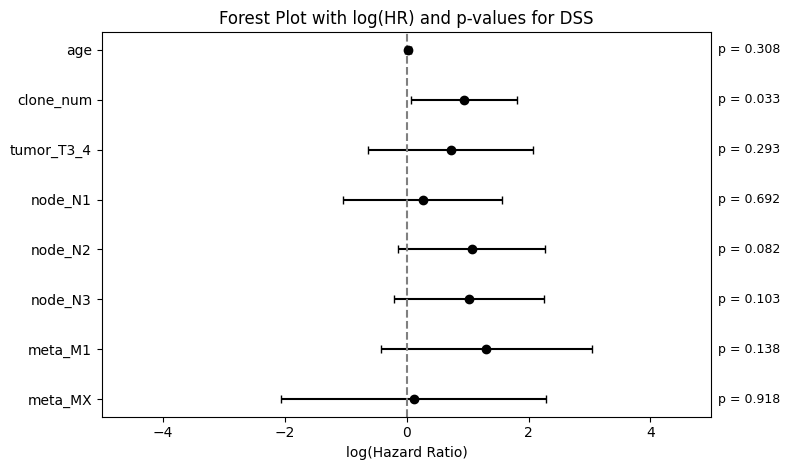

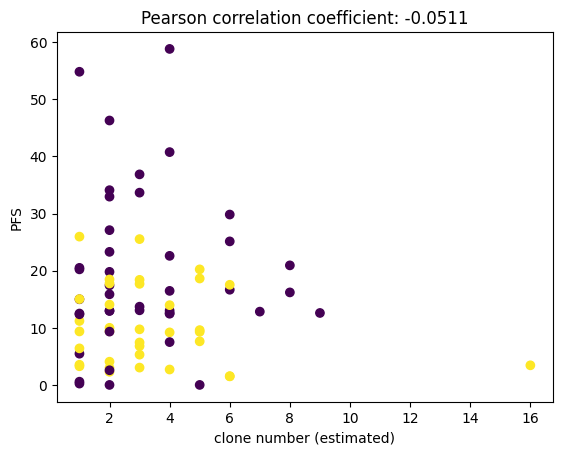

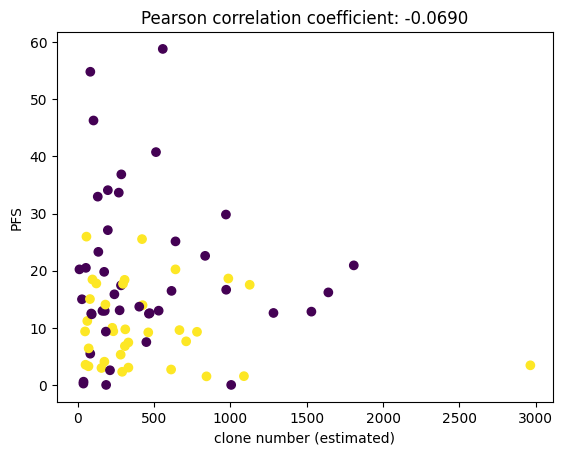

PFS


/home/shirasuna/anaconda3/envs/hetero_path_dev/lib/python3.9/site-packages/lifelines/utils/__init__.py:1120: ConvergenceWarning: Column node_NX have very low variance when conditioned on death event present or not. This may harm convergence. This could be a form of 'complete separation'. For example, try the following code:

>>> events = df['event'].astype(bool)
>>> print(df.loc[events, 'node_NX'].var())
>>> print(df.loc[~events, 'node_NX'].var())

A very low variance means that the column node_NX completely determines whether a subject dies or not. See https://stats.stackexchange.com/questions/11109/how-to-deal-with-perfect-separation-in-logistic-regression.

  warnings.warn(dedent(warning_text), ConvergenceWarning)
/home/shirasuna/anaconda3/envs/hetero_path_dev/lib/python3.9/site-packages/lifelines/fitters/coxph_fitter.py:1607: ConvergenceWarning: Newton-Raphson convergence completed successfully but norm(delta) is still high, 0.114. This may imply non-unique solutions to the maximum

<lifelines.CoxPHFitter: fitted with 77 total observations, 42 right-censored observations>
             duration col = 'duration'
                event col = 'event'
      baseline estimation = breslow
   number of observations = 77
number of events observed = 35
   partial log-likelihood = -123.32
         time fit was run = 2025-05-08 06:42:30 UTC

---
             coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                    
age          0.00      1.00      0.02           -0.04            0.04                0.96                1.04
clone_num    0.55      1.73      0.36           -0.16            1.26                0.85                3.52
tumor_T3_4  -0.45      0.64      0.50           -1.43            0.53                0.24                1.70
node_N1      0.28      1.33      0.60           -0.88            1.45                0.41                4.27
node_N2      1.44      4.23      0.52            0.41            2.47                1.51               11.81
node_N3      1.17      3.21      0.56            0.07            2.26                1.07                9.61
node_NX    -15.09      0.00   3175.41        -6238.78         6208.59                0.00                 inf
meta_M1      1.01      2.74      0.70           -0.37            2.39                0.69               10.86
meta_MX     -0.35      0.70      1.07           -2.45            1.74                0.09                5.70

            cmp to     z    p  -log2(p)
covariate                              
age           0.00  0.01 0.99      0.01
clone_num     0.00  1.53 0.13      2.97
tumor_T3_4    0.00 -0.90 0.37      1.43
node_N1       0.00  0.48 0.63      0.66
node_N2       0.00  2.75 0.01      7.39
node_N3       0.00  2.08 0.04      4.74
node_NX       0.00 -0.00 1.00      0.01
meta_M1       0.00  1.43 0.15      2.71
meta_MX       0.00 -0.33 0.74      0.43
---
Concordance = 0.69
Partial AIC = 264.64
log-likelihood ratio test = 15.85 on 9 df
-log2(p) of ll-ratio test = 3.83

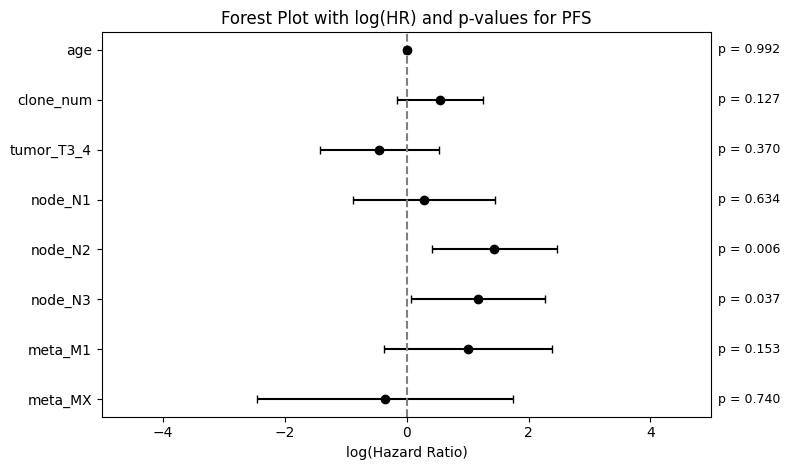

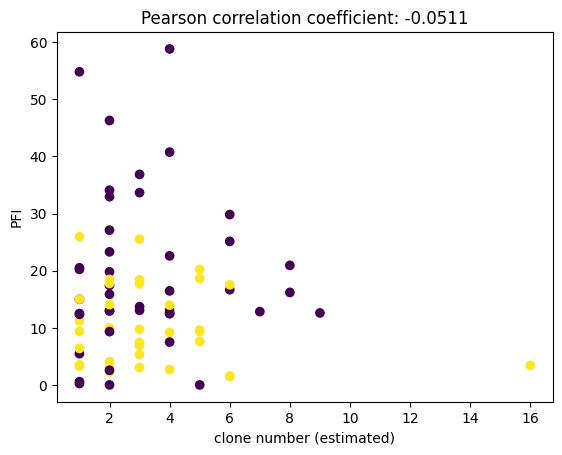

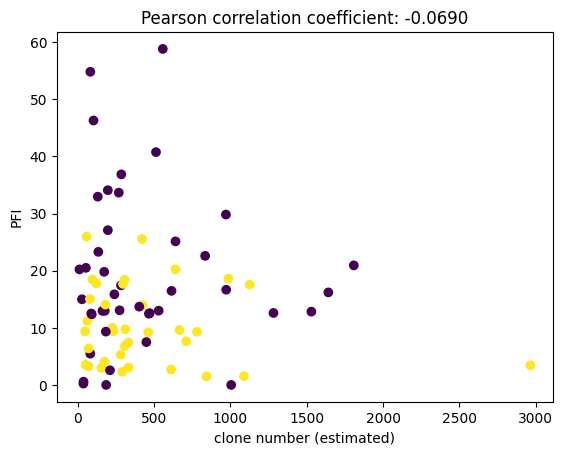

PFI


/home/shirasuna/anaconda3/envs/hetero_path_dev/lib/python3.9/site-packages/lifelines/utils/__init__.py:1120: ConvergenceWarning: Column node_NX have very low variance when conditioned on death event present or not. This may harm convergence. This could be a form of 'complete separation'. For example, try the following code:

>>> events = df['event'].astype(bool)
>>> print(df.loc[events, 'node_NX'].var())
>>> print(df.loc[~events, 'node_NX'].var())

A very low variance means that the column node_NX completely determines whether a subject dies or not. See https://stats.stackexchange.com/questions/11109/how-to-deal-with-perfect-separation-in-logistic-regression.

  warnings.warn(dedent(warning_text), ConvergenceWarning)
/home/shirasuna/anaconda3/envs/hetero_path_dev/lib/python3.9/site-packages/lifelines/fitters/coxph_fitter.py:1607: ConvergenceWarning: Newton-Raphson convergence completed successfully but norm(delta) is still high, 0.114. This may imply non-unique solutions to the maximum

<lifelines.CoxPHFitter: fitted with 77 total observations, 42 right-censored observations>
             duration col = 'duration'
                event col = 'event'
      baseline estimation = breslow
   number of observations = 77
number of events observed = 35
   partial log-likelihood = -123.32
         time fit was run = 2025-05-08 06:42:35 UTC

---
             coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                    
age          0.00      1.00      0.02           -0.04            0.04                0.96                1.04
clone_num    0.55      1.73      0.36           -0.16            1.26                0.85                3.52
tumor_T3_4  -0.45      0.64      0.50           -1.43            0.53                0.24                1.70
node_N1      0.28      1.33      0.60           -0.88            1.45                0.41                4.27
node_N2      1.44      4.23      0.52            0.41            2.47                1.51               11.81
node_N3      1.17      3.21      0.56            0.07            2.26                1.07                9.61
node_NX    -15.09      0.00   3175.41        -6238.78         6208.59                0.00                 inf
meta_M1      1.01      2.74      0.70           -0.37            2.39                0.69               10.86
meta_MX     -0.35      0.70      1.07           -2.45            1.74                0.09                5.70

            cmp to     z    p  -log2(p)
covariate                              
age           0.00  0.01 0.99      0.01
clone_num     0.00  1.53 0.13      2.97
tumor_T3_4    0.00 -0.90 0.37      1.43
node_N1       0.00  0.48 0.63      0.66
node_N2       0.00  2.75 0.01      7.39
node_N3       0.00  2.08 0.04      4.74
node_NX       0.00 -0.00 1.00      0.01
meta_M1       0.00  1.43 0.15      2.71
meta_MX       0.00 -0.33 0.74      0.43
---
Concordance = 0.69
Partial AIC = 264.64
log-likelihood ratio test = 15.85 on 9 df
-log2(p) of ll-ratio test = 3.83

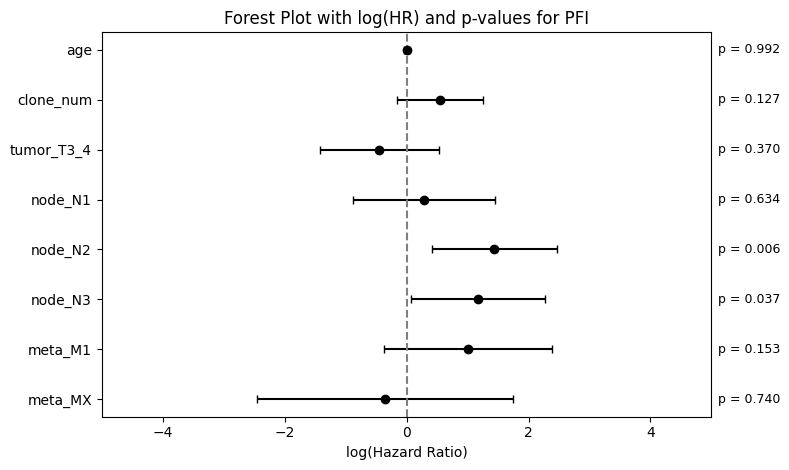

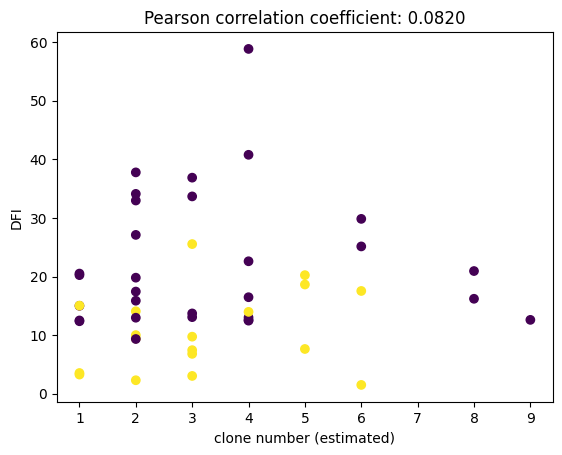

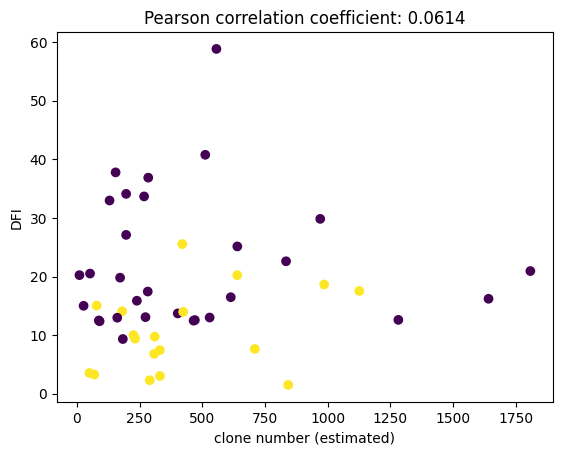

DFI


/home/shirasuna/anaconda3/envs/hetero_path_dev/lib/python3.9/site-packages/lifelines/utils/__init__.py:1120: ConvergenceWarning: Column node_NX have very low variance when conditioned on death event present or not. This may harm convergence. This could be a form of 'complete separation'. For example, try the following code:

>>> events = df['event'].astype(bool)
>>> print(df.loc[events, 'node_NX'].var())
>>> print(df.loc[~events, 'node_NX'].var())

A very low variance means that the column node_NX completely determines whether a subject dies or not. See https://stats.stackexchange.com/questions/11109/how-to-deal-with-perfect-separation-in-logistic-regression.

  warnings.warn(dedent(warning_text), ConvergenceWarning)
/home/shirasuna/anaconda3/envs/hetero_path_dev/lib/python3.9/site-packages/lifelines/utils/__init__.py:1163: ConvergenceWarning: Column node_NX has high sample correlation with the duration column. This may harm convergence. This could be a form of 'complete separation'.  

<lifelines.CoxPHFitter: fitted with 48 total observations, 30 right-censored observations>
             duration col = 'duration'
                event col = 'event'
      baseline estimation = breslow
   number of observations = 48
number of events observed = 18
   partial log-likelihood = -57.33
         time fit was run = 2025-05-08 06:42:38 UTC

---
             coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                    
age          0.03      1.03      0.03           -0.04            0.09                0.97                1.10
clone_num    0.56      1.75      0.53           -0.49            1.61                0.61                4.99
tumor_T3_4   0.63      1.89      0.95           -1.23            2.50                0.29               12.16
node_N1      0.58      1.78      0.76           -0.92            2.07                0.40                7.94
node_N2      1.08      2.94      0.83           -0.55            2.71                0.58               15.00
node_N3      1.32      3.76      0.74           -0.14            2.78                0.87               16.17
node_NX    -13.94      0.00   2449.17        -4814.22         4786.35                0.00                 inf
meta_MX      0.11      1.12      1.10           -2.05            2.27                0.13                9.73

            cmp to     z    p  -log2(p)
covariate                              
age           0.00  0.87 0.38      1.38
clone_num     0.00  1.05 0.30      1.76
tumor_T3_4    0.00  0.67 0.50      0.99
node_N1       0.00  0.76 0.45      1.16
node_N2       0.00  1.30 0.19      2.37
node_N3       0.00  1.78 0.08      3.73
node_NX       0.00 -0.01 1.00      0.01
meta_MX       0.00  0.10 0.92      0.12
---
Concordance = 0.68
Partial AIC = 130.65
log-likelihood ratio test = 9.16 on 8 df
-log2(p) of ll-ratio test = 1.60

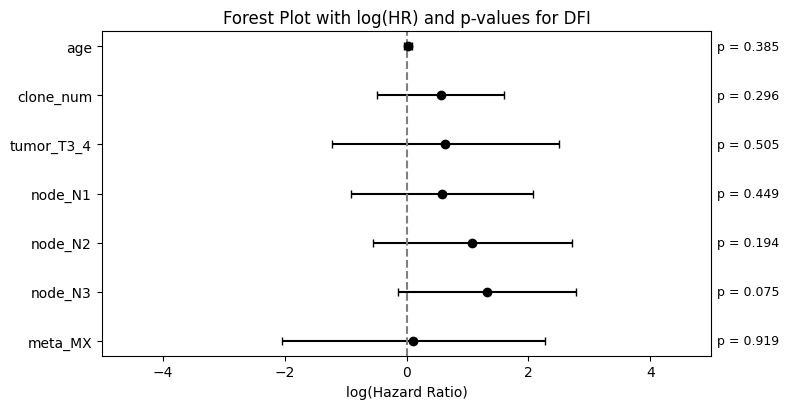

In [40]:
"""
prog_dict_list=[OS_dict,PFS_dict, DFI_dict]
prog_index_dict_list=[OS_index_dict,PFS_index_dict, DFI_index_dict]
metrics_name_list = ["OS", "PFS", "DFI"]
"""
prog_dict_list=[OS_dict, DSS_dict,PFS_dict,PFI_dict, DFI_dict]
prog_index_dict_list=[OS_index_dict, DSS_index_dict,PFS_index_dict,PFI_index_dict, DFI_index_dict]
metrics_name_list = ["OS", "DSS", "PFS", "PFI", "DFI"]

tum_threshold_value_in_chief=otsu_thresh


dir_path = "/home/shirasuna/work/hetero_path/hetero_cluster/clustering_pca80var_integrate_mag40_init20/"

samples_with_cluster_all = [
    f for f in os.listdir(dir_path) 
    if os.path.isdir(os.path.join(dir_path,f)) and f.startswith("TCGA")
]

###WGSと相関が取れるもののみ使用

"""
import pickle
# 読み込み
with open('good_samples.pkl', 'rb') as f:
    good_samples = pickle.load(f)
samples_with_cluster_all=list(set(samples_with_cluster_all)&set(good_samples))
"""



for i in range(len(metrics_name_list)):
    prog_dict = prog_dict_list[i]
    prog_index_dict = prog_index_dict_list[i]
    metrics_name=metrics_name_list[i]
    samples_with_cluster = list(set(samples_with_cluster_all)&set(list(prog_dict.keys())))

    
    prog_list=[]
    samples_for_plot_list=[]
    estimated_clone_num_list = []
    whole_patch_num_list = []
    patch_num_list = []
    tum_whole_ratio_list = []
    
    for temp_sample in samples_with_cluster:
        path_2_clustering = f"{dir_path}/{temp_sample}"
        optimized_state = np.load(f"{path_2_clustering}/optimized_state.npy")
        h5_file_path = f"/data/shirasuna/work/hetero_path/TCGA_wsi_patch/patched_STAD_mag40/patches/{temp_sample}.h5"
        h5_wsi = h5py.File(h5_file_path, 'r')
    
        EPI_FEATURE_SAVE_DIR_PATH = f"/data/shirasuna/work/hetero_path/UNI_encode_with_mask/features_mag40/{temp_sample}"
        epi_coords = np.load(f"{EPI_FEATURE_SAVE_DIR_PATH}/coords.npy")
        #epi_features = np.load(f"{EPI_FEATURE_SAVE_DIR_PATH}/features.npy")
    
        estimated_clone_num= len(np.unique(optimized_state))
    
        # chief
        chief_result_path =  f"/wsi/analysis/TCGA_TMA_analysis/data/CHIEF/STAD/chief/results/TCGA_Dataset_PT_trident/evaluation/TCGA_CHIEF_test/attention_heatmap_h5_coords_viz_v1/{temp_sample}_patch_attention.csv"
        chief_result_df = pd.read_csv(chief_result_path)
    
        
        # 4つの近傍のattension valueの平均で各座標のattension valueを定義
        x_coord_chief = chief_result_df["x_coord"].tolist()
        y_coord_chief = chief_result_df["y_coord"].tolist()
        attension_chief_list = chief_result_df["attention_value"].tolist()
        
        coord_chief = np.stack((x_coord_chief, y_coord_chief), axis =1)
        attension_chief_array = np.array(attension_chief_list) # shape=(N,) 例: (2903,)

        # --- KDTree を使用した最近傍探索 ---
        kdtree = KDTree(coord_chief)
        
        # 2. wsi_patch_coords の各点について、coord_tum_chief 内の最近傍点を検索
        #    queryメソッドは、距離(distances)と最近傍点のインデックス(indices)を返します。
        #    k=1 は最も近い1点を探すことを意味します。
        distances, nearest_indices = kdtree.query(epi_coords, k=4)
        
        # nearest_indices は、wsi_patch_coords の各点に対応する、
        # coord_tum_chief 内の最も近い点のインデックス（行番号）を格納した配列です。
        # shape=(M,) 例: (42849,)
        
        # 3. 得られたインデックスを使って、対応する attention 値を取得
        #    attension_chief_array から、nearest_indices を使って値を取り出します。

        wsi_attention_values = attension_chief_array[nearest_indices] # shape=(M,) 例: (42849,)
        
        ###平均のattension valueが4以上のclusterのみカウント
    
        mean_wsi_attention_values = np.mean(wsi_attention_values, axis=1)
        
        estimated_clone_num=0

        patch_num = 0
        for cluster in np.unique(optimized_state):
            mean_attension = np.sum(mean_wsi_attention_values[optimized_state==cluster])/np.sum(optimized_state==cluster)
            if mean_attension > tum_threshold_value_in_chief:
                estimated_clone_num+=1
                patch_num+=np.sum(optimized_state==cluster)
    
    
        # 例: create_knn_graph の出力を使用
    
        """
       
        g, nodes, nx_graph = create_knn_graph(epi_coords, k=4)  # coords は事前に定義されているとする
        cluster_components, cluster_component_ratios = compute_cluster_connected_components(nx_graph, optimized_state)
        
        print(f"クラスタごとの連結成分数: {cluster_components}")
        
        estimated_clone_num=0
        
        for cluster in cluster_component_ratios.keys():
            #if max(cluster_component_ratios[cluster])>0.25 and sum(optimized_state==cluster)/len(optimized_state)>1/len(np.unique(optimized_state))/5:
            if max(cluster_component_ratios[cluster])*sum(optimized_state==cluster) > 0.01*len(optimized_state):
                estimated_clone_num+=1
        """
        #estimated_clone_num= len(np.unique(optimized_state))
    
        
        prog_time = prog_dict[temp_sample]
        whole_patch_num= len(h5_wsi["coords"])
    
        samples_for_plot_list.append(temp_sample)
        prog_list.append(prog_time)
        estimated_clone_num_list.append(estimated_clone_num)
        patch_num_list.append(patch_num)
        whole_patch_num_list.append(whole_patch_num)
        tum_whole_ratio_list.append(patch_num/whole_patch_num)


    patch_25 = np.percentile(patch_num_list, 0)
    patch_75 = np.percentile(patch_num_list, 100)
    
    filtered_samples_for_plot_list=[]
    filtered_prog_list = []
    filtered_estimated_clone_num_list = []
    filtered_whole_patch_num_list = []
    filtered_patch_num_list = []
    filtered_tum_whole_ratio_list = []
    
    for i in range(len(samples_for_plot_list)):
        if patch_25<patch_num_list[i] and patch_75>patch_num_list[i]:
            filtered_samples_for_plot_list.append(samples_for_plot_list[i])
            filtered_prog_list.append(prog_list[i])
            filtered_estimated_clone_num_list.append(estimated_clone_num_list[i])
            filtered_whole_patch_num_list.append(whole_patch_num_list[i])
            filtered_patch_num_list.append(patch_num_list[i])
            filtered_tum_whole_ratio_list.append(tum_whole_ratio_list[i])


    #filtered_tum_size_list = [tum_size_dict[patient] for patient in filtered_samples_for_plot_list]

    #filtered_scaled_estimated_clone_num_list = [filtered_estimated_clone_num_list[i]*filtered_tum_size_list[i]/(filtered_patch_num_list[i]) for i in range(len(filtered_patch_num_list))]

    filtered_scaled_estimated_clone_num_list = [filtered_estimated_clone_num_list[i]*(filtered_patch_num_list[i])**(1/2) for i in range(len(filtered_patch_num_list))]

    #filtered_scaled_estimated_clone_num_list = [filtered_estimated_clone_num_list[i]*filtered_tum_size_list[i]/(filtered_whole_patch_num_list[i]) for i in range(len(filtered_patch_num_list))]
    #filtered_scaled_estimated_clone_num_list = [filtered_tum_size_list[i]/((filtered_whole_patch_num_list[i]/filtered_estimated_clone_num_list[i])**(3/2)) for i in range(len(filtered_patch_num_list))]

    #filtered_scaled_estimated_clone_num_list = [filtered_estimated_clone_num_list[i]/(filtered_whole_patch_num_list[i]) for i in range(len(filtered_patch_num_list))]
    
    event_list = []
    for temp_sample in filtered_samples_for_plot_list:
        #temp_index = int(prog_index_dict[temp_sample][0])
        temp_index = prog_index_dict[temp_sample]
        if temp_index ==0:
            event_list.append(0)
        else:
            event_list.append(1)
    

    
    corr_pearson = np.corrcoef(filtered_estimated_clone_num_list, filtered_prog_list)[0, 1]
    #print(f"Pearson correlation coefficient: {corr_pearson:.4f}")
    plt.scatter(filtered_estimated_clone_num_list, filtered_prog_list,c=event_list)
    plt.title(f"Pearson correlation coefficient: {corr_pearson:.4f}")
    plt.xlabel("clone number (estimated)")
    plt.ylabel(metrics_name) 
    plt.show()

    corr_pearson = np.corrcoef(filtered_scaled_estimated_clone_num_list, filtered_prog_list)[0, 1]
    #print(f"Pearson correlation coefficient: {corr_pearson:.4f}")
    plt.scatter(filtered_scaled_estimated_clone_num_list, filtered_prog_list,c=event_list)
    plt.title(f"Pearson correlation coefficient: {corr_pearson:.4f}")
    plt.xlabel("clone number (estimated)")
    plt.ylabel(metrics_name) 
    plt.show()


    """
    filtered_patch_num_list = [temp**(3/2) for temp in filtered_patch_num_list]
    low_threshold = np.percentile(filtered_patch_num_list, 25)
    high_threshold = np.percentile(filtered_patch_num_list, 25)
    
    
    # 上位25%（Q3以上）と下位25%（Q1以下）のインデックスを抽出
    group0_indices = [i for i, val in enumerate(filtered_patch_num_list) if val <= low_threshold]
    group1_indices = [i for i, val in enumerate(filtered_patch_num_list) if val > high_threshold]

    """

    
    low_threshold = np.percentile(filtered_scaled_estimated_clone_num_list, 50)
    high_threshold = np.percentile(filtered_scaled_estimated_clone_num_list,50)

    
    # 上位25%（Q3以上）と下位25%（Q1以下）のインデックスを抽出
    group0_indices = [i for i, val in enumerate(filtered_scaled_estimated_clone_num_list) if val <= low_threshold]
    group1_indices = [i for i, val in enumerate(filtered_scaled_estimated_clone_num_list) if val > high_threshold]
    
    

    # 対応する生存時間とイベント情報を取得
    T = np.array(filtered_prog_list)
    E = np.array(event_list)
    
    # グループごとのデータ
    T0, E0 = T[group0_indices], E[group0_indices]
    T1, E1 = T[group1_indices], E[group1_indices]

    # age data
    A0 = [age_dict[filtered_samples_for_plot_list[temp_idx]] for temp_idx in group0_indices]
    A1 = [age_dict[filtered_samples_for_plot_list[temp_idx]] for temp_idx in group1_indices]

    #state_data
    tumor0 = [T_dict[filtered_samples_for_plot_list[temp_idx]] for temp_idx in group0_indices]
    tumor0 = ["T1_2" if t in ["T1", "T2"] else "T3_4" if t in ["T3", "T4"] else t for t in tumor0]
    tumor1 = [T_dict[filtered_samples_for_plot_list[temp_idx]] for temp_idx in group1_indices]
    tumor1 = ["T1_2" if t in ["T1", "T2"] else "T3_4" if t in ["T3", "T4"] else t for t in tumor1]


    #node_data
    node0 = [N_dict[filtered_samples_for_plot_list[temp_idx]] for temp_idx in group0_indices]
    node0 = ["N3" if t in ["N3A", "N3B"] else t for t in node0]
    node1 = [N_dict[filtered_samples_for_plot_list[temp_idx]] for temp_idx in group1_indices]
    node1 = ["N3" if t in ["N3A", "N3B"] else t for t in node1]
    
    # meta data
    meta0 = [M_dict[filtered_samples_for_plot_list[temp_idx]] for temp_idx in group0_indices]
    meta1 = [M_dict[filtered_samples_for_plot_list[temp_idx]] for temp_idx in group1_indices]
    
    #stage_data
    S0 = [stage_dict[filtered_samples_for_plot_list[temp_idx]] for temp_idx in group0_indices]
    S1 = [stage_dict[filtered_samples_for_plot_list[temp_idx]] for temp_idx in group1_indices]
    
    df = pd.DataFrame({
        "duration": list(T0) + list(T1),
        "event": list(E0) + list(E1),
        "age": A0+A1,
        "tumor": tumor0+tumor1,
        "node": node0+node1,
        "meta": meta0+meta1,
        #"stage": S0+S1,
        "clone_num": [0]*len(T0) + [1]*len(T1)  # Low=0, High=1
    })
    df = pd.get_dummies(df, columns=["tumor", "node", "meta"], drop_first=True)

    cph = CoxPHFitter()
    cph.fit(df, duration_col="duration", event_col="event")
    
    # 結果表示
    print(metrics_name)
    cph.print_summary()

    # log(HR)（coef）と95% CIを取得
    summary_df = cph.summary.reset_index()
    summary_df = summary_df.rename(columns={"covariate": "variable"})  # ここが重要！
    summary_df = summary_df[summary_df["variable"] != "node_NX"]
    
    log_hr = summary_df["coef"]
    ci_lower = summary_df["coef lower 95%"]
    ci_upper = summary_df["coef upper 95%"]
    variables = summary_df["variable"]
    p_values = summary_df["p"]
    
    # NaN/inf を除外
    valid_idx = log_hr.replace([np.inf, -np.inf], np.nan).notnull()
    log_hr = log_hr[valid_idx]
    ci_lower = ci_lower[valid_idx]
    ci_upper = ci_upper[valid_idx]
    variables = variables[valid_idx]
    p_values = p_values[valid_idx]
    
    # プロット
    plt.figure(figsize=(8, len(log_hr) * 0.6))
    plt.errorbar(log_hr, range(len(log_hr)),
                 xerr=[log_hr - ci_lower, ci_upper - log_hr],
                 fmt='o', color='black', capsize=3)
    
    plt.yticks(range(len(variables)), variables)
    plt.axvline(0, color='gray', linestyle='--')  # log(HR)=0 → HR=1
    plt.xlabel("log(Hazard Ratio)")
    plt.title(f"Forest Plot with log(HR) and p-values for {metrics_name}")
    plt.xlim(-5, 5)
    
    # p値を右に表示
    for i, p in enumerate(p_values):
        if np.isfinite(p):
            plt.text(5.1, i, f"p = {p:.3f}", va='center', fontsize=9)
    
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.show()
    